# PoC: Logarithmic Query Number is Sufficient for ZOO

## Prepare

In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data

import numpy as np
import math
import time
import os
import matplotlib.pyplot as plt

from import_shelf import shelf
from shelf.models.transformer import VisionTransformer
from shelf.dataloaders.cifar import get_CIFAR10_dataset
from shelf.trainers.zeroth_order import learning_rate_estimate_second_order, gradient_fo, gradient_estimate_randvec, gradient_estimate_paramwise
from shelf.trainers.classic import train, validate

from tqdm import tqdm


In [2]:
### HYPERPARAMS ###

EPOCHS = 200
BATCH_SIZE = 512
IMAGE_SIZE = 32
PATCH_SIZE = 4
NUM_CLASSES = 10

NUM_QUERY = 1
LR_MAX = 1e-2
LR_MIN = 1e-5
SMOOTHING = 5e-4
R_PER_DECAY = 500
MOMENTUM = 0.95

MODEL_CONFIG = {
    "dim": 64,
    "depth": 4,
    "heads": 1,
    "mlp_dim": 64,
    "dropout": 0.1,
    "emb_dropout": 0.1,
}
# MODEL_CONFIG = {
#     "dim": 512,
#     "depth": 4,
#     "heads": 6,
#     "mlp_dim": 256,
#     "dropout": 0.1,
#     "emb_dropout": 0.1,
# }


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PATH_MODEL = './saves/zoo_poc.pth'
PATH_MODEL_BASE = './saves/zoo_poc_baseline.pth'


Files already downloaded and verified


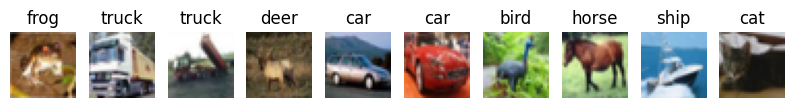

In [3]:
### DATA LOADING ###

train_loader, val_loader = get_CIFAR10_dataset(batch_size=BATCH_SIZE)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_loader.dataset.data[i])
    plt.title(classes[train_loader.dataset.targets[i]])
    plt.axis('off')

## Baseline: FOO

In [4]:
### MODEL ###

model_base = VisionTransformer(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_classes=NUM_CLASSES,
    **MODEL_CONFIG
).to(DEVICE)

num_params = sum(p.numel() for p in model_base.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")


### OTHERS ###

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_base.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

if os.path.exists(PATH_MODEL_BASE):
    model_base.load_state_dict(torch.load(PATH_MODEL_BASE))
else:
    for epoch in range(EPOCHS):
        start_time = time.time()

        lr = scheduler.get_last_lr()[0]

        train_acc, train_loss = train(train_loader, model_base, criterion, optimizer, epoch)
        val_acc, val_loss = validate(val_loader, model_base, criterion, epoch)

        scheduler.step()

        print(
            f"Epoch {epoch+1:3d}/{EPOCHS}, "
            f"LR: {lr:.4e} | "
            f"Train Acc: {train_acc * 100:.2f}%, "
            f"Train Loss: {train_loss:.4f}, "
            f"Val Acc: {val_acc*100:.2f}%, "
            f"Val Loss: {val_loss:.4f} | "
            f"Time: {time.time() - start_time:.3f}s"
        )

    torch.save(model_base.state_dict(), PATH_MODEL_BASE)

val_acc, val_loss = validate(val_loader, model_base, criterion, 0)
print(f"Val Acc: {val_acc*100:.2f}%, Val Loss: {val_loss:.4f}")

Number of parameters: 91594


Val Acc: 74.31%, Val Loss: 0.7294


## GGE-ZO Training

In [5]:
### MODEL ###

model = VisionTransformer(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_classes=NUM_CLASSES,
    **MODEL_CONFIG
).to(DEVICE)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_groups = int(np.log(num_params) / np.log(1.1))
print(f"Number of parameters: {num_params}")
print(f"Number of groups: {num_groups}")

Number of parameters: 91594
Number of groups: 119


In [6]:
### OTHERS ###

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def calc_decay_rate(gradient_momentum):
    all_gradients = torch.cat([grad.flatten() for grad in gradient_momentum.values()]).abs()
    all_gradients = torch.sort(all_gradients, descending=True).values
    
    x = np.arange(all_gradients.size(0))
    y = np.log(all_gradients.cpu().numpy() + 1e-8)
    
    a, B_log = np.polyfit(x, y, 1)

    return -a

def calc_r_by_gnum(N, d):
    equation = np.poly1d([1] + [0 for _ in range(N-1)] + [-d, d-1], False)
    roots = np.roots(equation)
    roots = roots[np.isreal(roots)]
    r = np.real(np.max(roots))

    if r <= 1:
        raise ValueError("r must be greater than 1")

    return r

def group_by_gradient_exp(estimated_gradient, num_groups, descending=True):
    all_gradients = torch.cat([grad.flatten() for grad in estimated_gradient.values()]).abs()
    all_gradients = torch.sort(all_gradients, descending=descending).values
    num_params = all_gradients.size(0)

    # Calculate r
    r = calc_r_by_gnum(num_groups, num_params)

    # Find milestones
    milestones = []
    group_size = 1
    group_start_idx = 0
    for group_idx in range(num_groups):
        milestones.append(all_gradients[group_start_idx])
        group_start_idx += math.floor(group_size)
        group_size *= r
    
    milestones[-1] = all_gradients[-1]

    # Group the parameters
    group_dict = {}
    for name, grad in estimated_gradient.items():
        group_dict[name] = torch.zeros_like(grad)
        for i, milestone in enumerate(milestones[::-1]):
            group_idx = num_groups - i - 1
            if descending:
                group_dict[name][grad.abs() >= milestone] = group_idx
            else:
                group_dict[name][grad.abs() <= milestone] = group_idx

    return group_dict

def group_by_given_logr(estimated_gradient, logr, descending=True):
    all_gradients = torch.cat([grad.flatten() for grad in estimated_gradient.values()]).abs()
    num_params = all_gradients.size(0)

    num_groups = int(np.log(np.exp(np.log(num_params) + logr) - num_params + 1) / logr)
    
    group_dict = group_by_gradient_exp(estimated_gradient, num_groups, descending)

    return group_dict, num_groups

In [8]:
@torch.no_grad()
def gradient_estimate_groupwise(input, label, model, criterion, num_groups, group_dict, query=1, smoothing=5e-4):
    model.eval()

    state_dict = model.state_dict()

    # Get statistics
    group_sizes = []
    for g in range(num_groups):
        group_sizes.append(sum([torch.sum(group_dict[name] == g).item() for name in group_dict.keys()]))

    # Prepare the result dictionary
    result_gradient = {}
    scaled_gradient = {}
    for name, param in model.named_parameters():
        if not param.requires_grad: continue
        result_gradient[name] = torch.zeros_like(param.data)
        scaled_gradient[name] = torch.zeros_like(param.data)

    # Original loss
    loss_original = criterion(model(input), label)

    # Perturb and measure the loss
    for q in range(query):
        noise = {}
        for name, param in model.named_parameters():
            if not param.requires_grad: continue
            noise[name] = torch.normal(mean=0, std=1, size=param.data.size(), device=param.data.device, dtype=param.data.dtype)

        for g in range(num_groups):
            estimated_gradient = {}
            group_norm = 0
            group_size = 0

            # generate the perturbation
            for name, param in model.named_parameters():
                if not param.requires_grad: continue
                
                # check group existence
                group_mask = group_dict[name] == g
                num_groups_in_param = torch.sum(group_mask).item()
                group_size += num_groups_in_param
                if num_groups_in_param == 0:
                    continue

                # generate the perturbation
                estimated_gradient[name] = noise[name].clone()
                
                # handle pruned parameters
                if '_orig' in name and name.replace('_orig', '_mask') in state_dict:
                    mask = state_dict[name.replace('_orig', '_mask')]
                    estimated_gradient[name] *= mask
                
                # handle grouping
                estimated_gradient[name] *= group_mask

                group_norm += torch.norm(estimated_gradient[name].flatten(), p=2).item() ** 2

            group_norm = math.sqrt(group_norm)

            # add the perturbation
            for name, param in model.named_parameters():
                if not param.requires_grad: continue

                # check group existence
                if name not in estimated_gradient: continue

                param.data += estimated_gradient[name] * smoothing

            # measure the loss
            loss_perturbed = criterion(model(input), label)
            loss_difference = (loss_perturbed - loss_original) / smoothing

            # restore and accumulate the model
            for name, param in model.named_parameters():
                if not param.requires_grad: continue

                # check group existence
                if name not in estimated_gradient: continue

                # restore the model
                param.data -= estimated_gradient[name] * smoothing
            
                # accumulate the gradient
                result_gradient[name] += loss_difference * estimated_gradient[name]
                scaled_gradient[name] += loss_difference * estimated_gradient[name] / group_norm
    
    # Average the gradient
    for name, param in model.named_parameters():
        if not param.requires_grad: continue
        result_gradient[name] /= query
        scaled_gradient[name] /= query
    
    return result_gradient, scaled_gradient


In [9]:
def train_zo(
        train_loader, model, criterion, optimizer, epoch,
        smoothing=1e-3, query=1, lr_auto=True, lr_max=1e-2, lr_min=1e-5, momentum=0.9,
        num_groups=1, group_dict=None, momentum_dict=None, decay_rate=None, r_per_decay=500, cheating_freq=5,
        config=None
    ):
    model.eval()

    print(f"LR Max: {lr_max:.4e}")

    # Prepare statistics
    num_data = 0
    num_correct = 0
    sum_loss = 0
    num_query = 0
    num_bp = 0
    
    lr_history = []
    sum_decay_rate = 0

    sum_cosine_sim = 0

    sum_group_diff = 0

    # Prepare grouping
    if group_dict == None:
        input, label = next(iter(train_loader))
        input = input.cuda()
        label = label.cuda()

        real_gradient = gradient_fo(input, label, model, criterion)

        group_dict = group_by_gradient_exp(real_gradient, num_groups)

        estimated_gradient = real_gradient

    if momentum_dict == None:
        momentum_dict = {}
        for name, param in model.named_parameters():
            if not param.requires_grad: continue
            momentum_dict[name] = torch.zeros_like(param.data)
    gradient_momentum = momentum_dict
        
    if decay_rate == None:
        if estimated_gradient == None:
            input, label = next(iter(train_loader))
            input = input.cuda()
            label = label.cuda()

            estimated_gradient = gradient_fo(input, label, model, criterion)

        decay_rate = calc_decay_rate(estimated_gradient)
    

    # Train the model
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False)
    len_train_loader = len(train_loader)
    cheating_num = len_train_loader // cheating_freq
    for i, (input, label) in enumerate(pbar):
        input = input.cuda()
        label = label.cuda()

        optimizer.zero_grad()

        # Gradient estimation
        real_gradient = gradient_fo(input, label, model, criterion)
        estimated_gradient, scaled_estimated_gradient = gradient_estimate_groupwise(input, label, model, criterion, num_groups, group_dict, query, smoothing)
        # rge_gradient = gradient_estimate_randvec(input, label, model, criterion, query=num_groups*query, smoothing=smoothing)
        # pge_gradient = gradient_estimate_paramwise(input, label, model, criterion, query=num_groups*query, smoothing=smoothing)
        num_query += query * num_groups

        # Cosine similarity
        all_real_gradients = torch.cat([grad.flatten() for grad in real_gradient.values()])
        all_estimated_gradients = torch.cat([grad.flatten() for grad in scaled_estimated_gradient.values()])
        # all_rge_gradients = torch.cat([grad.flatten() for grad in rge_gradient.values()])
        # all_pge_gradients = torch.cat([grad.flatten() for grad in pge_gradient.values()])

        real_norm = all_real_gradients.norm()
        estimated_norm = all_estimated_gradients.norm()
        # rge_norm = all_rge_gradients.norm()
        # pge_norm = all_pge_gradients.norm()
        
        cosine_similarity = (all_real_gradients * all_estimated_gradients).sum() / (real_norm * estimated_norm)
        # rge_cosine_similarity = (all_real_gradients * all_rge_gradients).sum() / (real_norm * rge_norm)
        # pge_cosine_similarity = (all_real_gradients * all_pge_gradients).sum() / (real_norm * pge_norm)

        # Apply gradient
        for name, param in model.named_parameters():
            if not param.requires_grad: continue
            param.grad = scaled_estimated_gradient[name]

        # Estimate learning rate
        lr = lr_min
        lr_estimated = 0
        if lr_auto:
            lr_estimated = learning_rate_estimate_second_order(input, label, model, criterion, scaled_estimated_gradient, smoothing=smoothing, scale_by_num_params=False)
            lr = max(lr_estimated.item(), lr_min) if lr_estimated != 0 else lr

            num_query += 3

        lr = min(lr, lr_max)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        lr_history.append(lr)

        # Update momentum
        for name, param in model.named_parameters():
            if not param.requires_grad: continue
            gradient_momentum[name] = momentum * gradient_momentum[name] + (1 - momentum) * estimated_gradient[name]

        # Update group
        if i % cheating_num == 0:
            real_gradient = gradient_fo(input, label, model, criterion)
            new_group_dict, num_groups = group_by_given_logr(real_gradient, decay_rate * r_per_decay)
            gradient_momentum = real_gradient
            
            new_decay_rate = calc_decay_rate(gradient_momentum)
            if not np.isnan(new_decay_rate): decay_rate = new_decay_rate

            num_bp += 1
        else:
            new_group_dict, num_groups = group_by_given_logr(gradient_momentum, decay_rate * r_per_decay)

        # Compare the group dict
        all_group_old = torch.cat([group_dict[name].flatten() for name in group_dict.keys()])
        all_group_new = torch.cat([new_group_dict[name].flatten() for name in new_group_dict.keys()])
        num_diff = torch.sum(all_group_old != all_group_new).item()
        group_diff_ratio = num_diff / all_group_old.size(0)
        sum_group_diff += group_diff_ratio

        group_dict = new_group_dict

        
        sum_decay_rate += decay_rate
        
        # Update the model
        optimizer.step()

        # Statistics
        output = model(input)
        loss = criterion(output, label)

        _, predicted = torch.max(output.data, 1)
        num_data += label.size(0)
        num_correct += (predicted == label).sum().item()
        sum_loss += loss.item() * label.size(0)
    
        accuracy = num_correct / num_data
        avg_loss = sum_loss / num_data

        sum_cosine_sim += cosine_similarity.item()

        # print(
        #     f"GGE: sim {cosine_similarity.item():.4f}, mag {estimated_norm.item()/real_norm.item():.4f} | "
        #     f"RGE: sim {rge_cosine_similarity.item():.4f}, mag {rge_norm.item()/real_norm.item():.4f} | "
        #     f"PGE: sim {pge_cosine_similarity.item():.4f}, mag {pge_norm.item()/real_norm.item():.4f} | "
        # )

        pbar.set_postfix(
            lr=f"{lr:.4e}",
            group_diff=f"{group_diff_ratio:.4f}",
            gge_cossim=cosine_similarity.item(), gge_mag=estimated_norm.item()/real_norm.item(),
            # rge_cossim=rge_cosine_similarity.item(), rge_mag=rge_norm.item()/real_norm.item(),
            train_accuracy=accuracy, train_loss=avg_loss, decay_rate=decay_rate, num_groups=num_groups
        )

    accuracy = num_correct / num_data
    avg_loss = sum_loss / num_data
    cosine_similarity = sum_cosine_sim / len(train_loader)

    if config is not None:
        config['lr_avg'] = np.mean(lr_history)
        config['lr_std'] = np.std(lr_history)
        config['num_query'] = num_query
        config['group_dict'] = group_dict
        config['decay_rate_avg'] = sum_decay_rate / len(train_loader)
        config['cosine_similarity'] = cosine_similarity
        config['momentum_dict'] = gradient_momentum
        config['num_bp'] = num_bp
        config['group_diff'] = sum_group_diff / len(train_loader)

    return accuracy, avg_loss

In [10]:
group_dict = None
momentum_dict = None
decay_rate = None

lr_max = LR_MAX

for epoch in range(EPOCHS):
    start_time = time.time()

    lr_max *= 0.5 ** (1/30)

    config = {}

    train_acc, train_loss = train_zo(
        train_loader, model, criterion, optimizer, epoch,
        smoothing=SMOOTHING, query=NUM_QUERY, lr_auto=True, lr_max=lr_max, lr_min=LR_MIN, momentum=MOMENTUM,
        num_groups=num_groups, group_dict=group_dict, momentum_dict=momentum_dict, decay_rate=decay_rate, r_per_decay=R_PER_DECAY,
        config=config
    )
    val_acc, val_loss = validate(val_loader, model, criterion, epoch)

    lr_avg = config['lr_avg']
    lr_std = config['lr_std']
    group_dict = config['group_dict']
    momentum_dict = config['momentum_dict']
    num_bp = config['num_bp']
    group_diff = config['group_diff']
    decay_rate = config['decay_rate_avg']

    print(
        f"Epoch {epoch+1:3d}/{EPOCHS}, "
        f"LR: {lr_avg:.6f}±{lr_std:.6f}, "
        f"Decay Rate: {config['decay_rate_avg']:.4e}, "
        f"Cosine Sim: {config['cosine_similarity']:.4f}, "
        f"Group Diff: {group_diff:.4f} | "
        f"Train Acc: {train_acc * 100:.2f}%, "
        f"Train Loss: {train_loss:.4f}, "
        f"Val Acc: {val_acc*100:.2f}%, "
        f"Val Loss: {val_loss:.4f} | "
        f"Num Query: {config['num_query']}, "
        f"Num BP: {num_bp}, "
        f"Time: {time.time() - start_time:.3f}s"
    )

    # momentum_len = len(momentum_dict)
    # fig_newline = 5

    # fig, ax = plt.subplots(momentum_len // fig_newline + 1, fig_newline, figsize=(20, 20))

    # for i, (key, value) in enumerate(momentum_dict.items()):

    #     value = value.flatten()
    #     value = value.cpu().abs().numpy()

    #     ax[i // fig_newline, i % fig_newline].plot(value)
    #     ax[i // fig_newline, i % fig_newline].set_title(f"{key}")

    # plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # plt.show()

torch.save(model.state_dict(), PATH_MODEL)

NameError: name 'lr_max' is not defined

In [ ]:
EXTRA_EPOCH = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EXTRA_EPOCH):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_acc, val_loss = validate(val_loader, model, criterion, epoch)

    print(
        f"Epoch {epoch+1:3d}/{EXTRA_EPOCH} | "
        f"Train Acc: {train_acc * 100:.2f}%, "
        f"Train Loss: {train_loss:.4f}, "
        f"Val Acc: {val_acc*100:.2f}%, "
        f"Val Loss: {val_loss:.4f}"
    )
    

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, epoch_pbar=None, verbose=True):
    gradient_distribution = {}

    model.train()

    num_data = 0
    num_correct = 0
    sum_loss = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False) if verbose else train_loader
    for input, label in pbar:
        input = input.cuda()
        label = label.cuda()

        output = model(input)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        target_grad_0 = model.transformer.layers[0][0].fn.to_qkv.weight.grad
        # target_grad_1 = model.transformer.layers[0][0].fn.to_out[0].weight.grad
        target_grad_2 = model.transformer.layers[0][1].fn.net[0].weight.grad
        target_grad_3 = model.transformer.layers[0][1].fn.net[3].weight.grad

        gradient_distribution['0.to_qkv'] = target_grad_0.detach().cpu().numpy()
        # gradient_distribution['0.to_out'] = target_grad_1.detach().cpu().numpy()
        gradient_distribution['0.fc1'] = target_grad_2.detach().cpu().numpy()
        gradient_distribution['0.fc2'] = target_grad_3.detach().cpu().numpy()

        return gradient_distribution

In [ ]:
### TRAINING ###

gradient_distribution = train(train_loader, model, criterion, optimizer, 0, verbose=False)

### GRADIENT DISTRIBUTION ###

NUM_QUERY = 128

fig, ax = plt.subplots(2, 3, figsize=(20, 5))
# fig, ax = plt.subplots(2, 4, figsize=(20, 5))

for i, (key, value) in enumerate(gradient_distribution.items()):
    value = value.flatten()
    value = np.power(value, 2)
    value = -np.sort(-value)

    norm = np.sum(value)

    subnorm = 0
    
    now_idx = 0
    dimension = value.shape[0]

    for j in range(NUM_QUERY):
        next_idx = now_idx + dimension // NUM_QUERY
        subnorm += np.sum(value[now_idx:next_idx]) * (next_idx - now_idx)
        now_idx = next_idx
    
    subnorm += np.sum(value[now_idx:]) * (dimension - now_idx)

    ax[0][i].plot(value)
    ax[0][i].set_title(f'{key} - {subnorm / norm:.2f} ({NUM_QUERY})')

    ax[1][i].plot(value)
    ax[1][i].set_yscale('log')

    
plt.show()

In [ ]:
torch.save(model.state_dict(), PATH_MODEL)

In [ ]:
model.load_state_dict(torch.load(PATH_MODEL))

In [ ]:
val_acc, val_loss = validate(val_loader, model, criterion, 0)
print(f"Val Acc: {val_acc*100:.2f}%, Val Loss: {val_loss:.4f}")